In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss
from lstm2 import LSTMModel

In [4]:
x = np.loadtxt("x.dat", np.float32)
y = np.loadtxt("y.dat", np.float32)
x = x.reshape(x.shape[0], x.shape[1]//2, 2)
y = y.reshape(y.shape[0], y.shape[1]//1, 1)
grid = np.linspace(0, 1, 100, dtype=np.float32).reshape((100, 1))

print(x.shape)
print(y.shape)
print(grid.shape)

(1000, 100, 2)
(1000, 100, 1)
(100, 1)


In [5]:
# Parameters
nt = 100
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50

In [6]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [7]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [10]:
model = LSTMModel(400, 2, 1).cuda()
print(count_params(model))

646801


In [11]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [12]:
loss = LpLoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = out.reshape((out.shape[0], out.shape[1]))        
        
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            out = out.reshape((out.shape[0], out.shape[1]))
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))

0 0.31591719784773886 0.6892311930656433 0.6102128744125366
50 0.2088228438515216 0.03881664541032579 0.03436644524335861
100 0.1679584060329944 0.01960140737808413 0.01654859781265259
150 0.16961354785598814 0.013621350915895569 0.014592718705534935
200 0.16874616709537804 0.011925909688903226 0.011264205910265446
250 0.17154277698136866 0.011046156783898671 0.010206563025712967
300 0.16893833014182746 0.010478019021037552 0.009840552136301995
350 0.16889748210087419 0.010133711310724417 0.009552104771137238
400 0.1683046978432685 0.009978469109369649 0.009534559864550828
450 0.1686906439717859 0.009892136893338628 0.00944390082731843
500 0.21114933700300753 0.009847082746111685 0.009404550865292549
550 0.20894022495485842 0.009822351526882914 0.009382623061537743
600 0.1676689530722797 0.009813931905147103 0.009378333669155836
650 0.16923926398158073 0.009808318275544379 0.009371274430304766
700 0.17147555900737643 0.009804136637184355 0.00937045579776168
750 0.16979963798075914 0.00

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


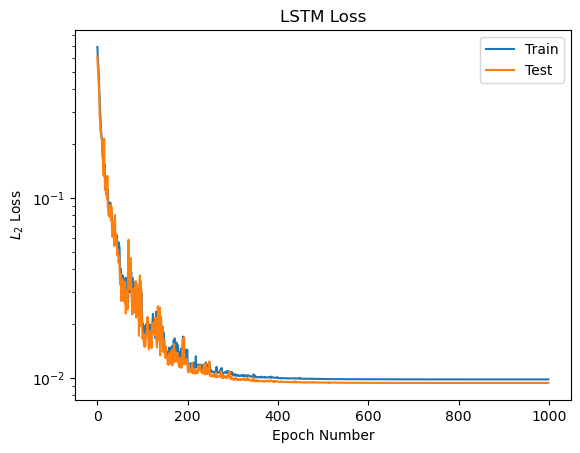

In [20]:
plt.plot(train_lossArr, label="Train")
plt.plot(test_lossArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.title("LSTM Loss")
plt.legend()
plt.savefig("lstmLinearLoss.eps")

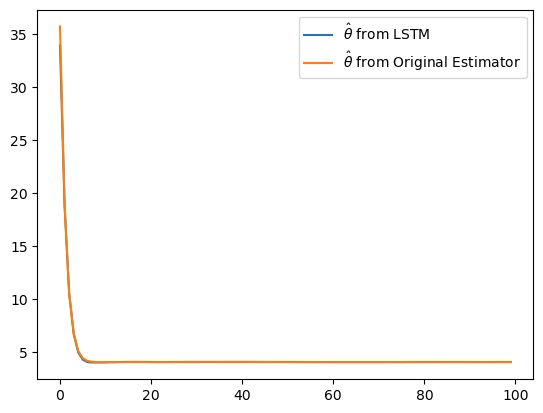

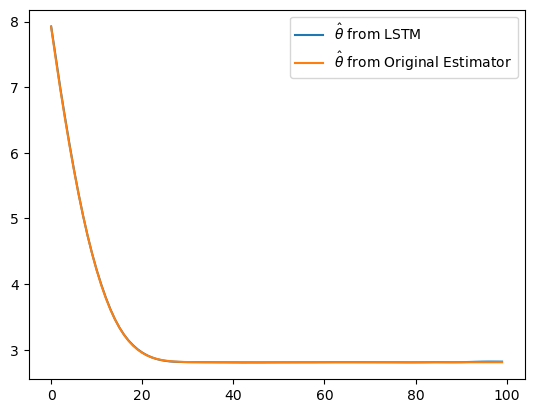

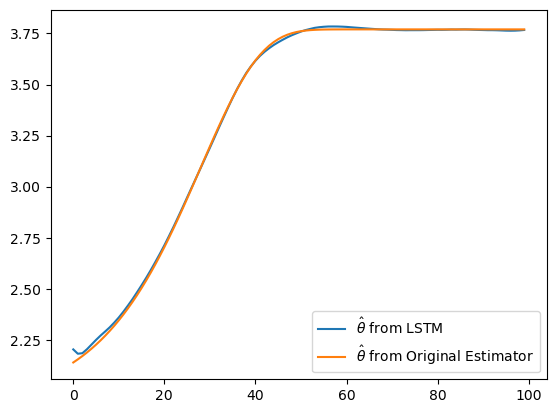

In [15]:
# Show some examples
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        
    for i in range(3):
        plt.figure()
        plt.plot(out[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from LSTM")
        plt.plot(y[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from Original Estimator")
        plt.legend()

In [16]:
with torch.no_grad():
    out_theta = []
    guess_theta = []
    test_loss = 0
    loss_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)
        out = out.reshape((out.shape[0], out.shape[1]))
        
        for i in range(len(y)):
            out_theta.append(y[i][-1].cpu().detach())
            guess_theta.append(out[i][-1].cpu().detach())
            loss_end += (out_theta[-1]-guess_theta[-1])**2
        
        test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print("TEST MSE:", test_loss/len(testData))
print("TEST MSE FINAL VALUE:", loss_end.item()/len(testData))

TEST MSE: 0.009369553811848164
TEST MSE FINAL VALUE: 0.007127539813518524


/home/luke/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/luke/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0, 0.5, 'Final $\\hat{\\theta}$ from LSTM')

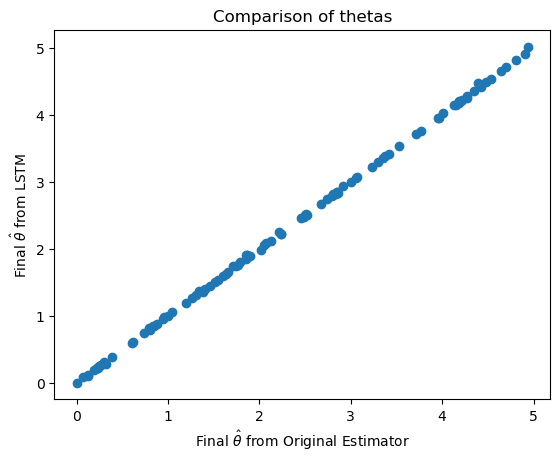

In [17]:
plt.title("Comparison of thetas")
plt.scatter(out_theta, guess_theta)
plt.xlabel(r"Final $\hat{\theta}$ from Original Estimator")
plt.ylabel(r"Final $\hat{\theta}$ from LSTM")

In [18]:
# Save Model
torch.save(model.state_dict(), "lstmModel1")